In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *
from IPython.core.debugger import set_trace

In [3]:
torch.cuda.is_available(), torch.backends.cudnn.enabled

(True, True)

In [4]:
PATH=Path('/home/sean/data/ISIC2016/')
if not PATH.exists():
    PATH.mkdir()

trn = 'ISBI2016_ISIC_Part3_Training_GroundTruth.csv'

train_csv = PATH / 'train.csv'

In [19]:
gt = pd.read_csv(PATH / trn, header=None)
gt.columns = ['image', 'class']
# gt.to_csv(train_csv)
gt.head()

,image,class
0,ISIC_0000000,benign
1,ISIC_0000001,benign
2,ISIC_0000002,malignant
3,ISIC_0000004,malignant
4,ISIC_0000006,benign


## Pandas Ground Truth Formatting

benign       727
malignant    173
Name: class, dtype: int64


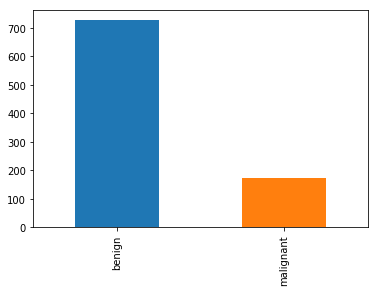

In [32]:
tdf = gt.set_index('image', inplace=False)
# tdf = pd.read_csv(train_csv)
# tdf.columns = ['image', 'class']
print(tdf['class'].value_counts())
tdf['class'].value_counts().plot(kind='bar')

In [36]:
tdf.head()

,class
image,
ISIC_0000000,benign
ISIC_0000001,benign
ISIC_0000002,malignant
ISIC_0000004,malignant
ISIC_0000006,benign


In [50]:
tdf.columns

Index(['class'], dtype='object')

In [41]:
tdf.to_csv(train_csv)

## Data Loader for Training

In [12]:
def rand_by_mask(mask, preds, mpl=4): return np.random.choice(np.where(mask)[0], min(len(preds), mpl), replace=False)
def rand_by_correct(is_correct, preds, val_y): return rand_by_mask((preds == val_y)==is_correct, preds)
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
def load_img_id(ds, idx): return np.array(PIL.Image.open(str(PATH / ds.fnames[idx])))

In [6]:
%ls $PATH

ISBI2016_ISIC_Part3_Test_Data/
ISBI2016_ISIC_Part3_Test_Data.zip
ISBI2016_ISIC_Part3_Test_GroundTruth.csv
ISBI2016_ISIC_Part3_Training_Data/
ISBI2016_ISIC_Part3_Training_Data.zip
ISBI2016_ISIC_Part3_Training_GroundTruth.csv
models/
test.csv
tmp/
train.csv


In [25]:
train_csv

PosixPath('/home/sean/data/ISIC2016/train.csv')

In [23]:
# The network architecture to use, resnet34 is a good start, will get better performance with resnext50 or inceptionv4
arch=inception_4
# image size
sz=224
bs=8

# Dataset augmentations
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down)
# The dataloader, used for training and evaluation, has numerous useful functions for:
# loading data, preprocessing, batching, obtaining basic stats, and more
data = ImageClassifierData.from_csv(PATH, 'ISBI2016_ISIC_Part3_Training_Data', train_csv, tfms=tfms,
                    suffix='.jpg', bs=bs, test_name='ISBI2016_ISIC_Part3_Test_Data')

In [22]:
??inception_4

In [8]:
data.classes, len(data.classes)

(['benign', 'malignant'], 2)

In [9]:
data.trn_ds.n, data.trn_ds.fnames[0:10], data.trn_y[0:10]

(720, array(['ISBI2016_ISIC_Part3_Training_Data/ISIC_0000000.jpg',
        'ISBI2016_ISIC_Part3_Training_Data/ISIC_0000001.jpg',
        'ISBI2016_ISIC_Part3_Training_Data/ISIC_0000002.jpg',
        'ISBI2016_ISIC_Part3_Training_Data/ISIC_0000004.jpg',
        'ISBI2016_ISIC_Part3_Training_Data/ISIC_0000006.jpg',
        'ISBI2016_ISIC_Part3_Training_Data/ISIC_0000008.jpg',
        'ISBI2016_ISIC_Part3_Training_Data/ISIC_0000009.jpg',
        'ISBI2016_ISIC_Part3_Training_Data/ISIC_0000010.jpg',
        'ISBI2016_ISIC_Part3_Training_Data/ISIC_0000011.jpg',
        'ISBI2016_ISIC_Part3_Training_Data/ISIC_0000016.jpg'], dtype='<U50'), array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0]))

Show images from the different classes

In [10]:
cls2n = {0: 'benign', 1: 'malignant'}
def sample_ims(c, ys=data.trn_y, ds=data.trn_ds, numimgs=9, figsize=(24,12)):
    idm = rand_by_mask(c == ys, ys, mpl=numimgs)
    ims = [load_img_id(ds, i) for i in idm]
    r = np.ceil(len(ims) / 3).astype(int)
    tt = 'Sample {} images (class id={}; {} total)'.format(cls2n[c], c, np.sum(ys==c))
    plots(ims, figsize=figsize, rows=r, titles=["Im Id: {}".format(i) for i in idm])
    plt.suptitle(tt, fontsize=24)
np.sum(data.trn_y == 1), np.sum(data.trn_y == 0)

(141, 579)

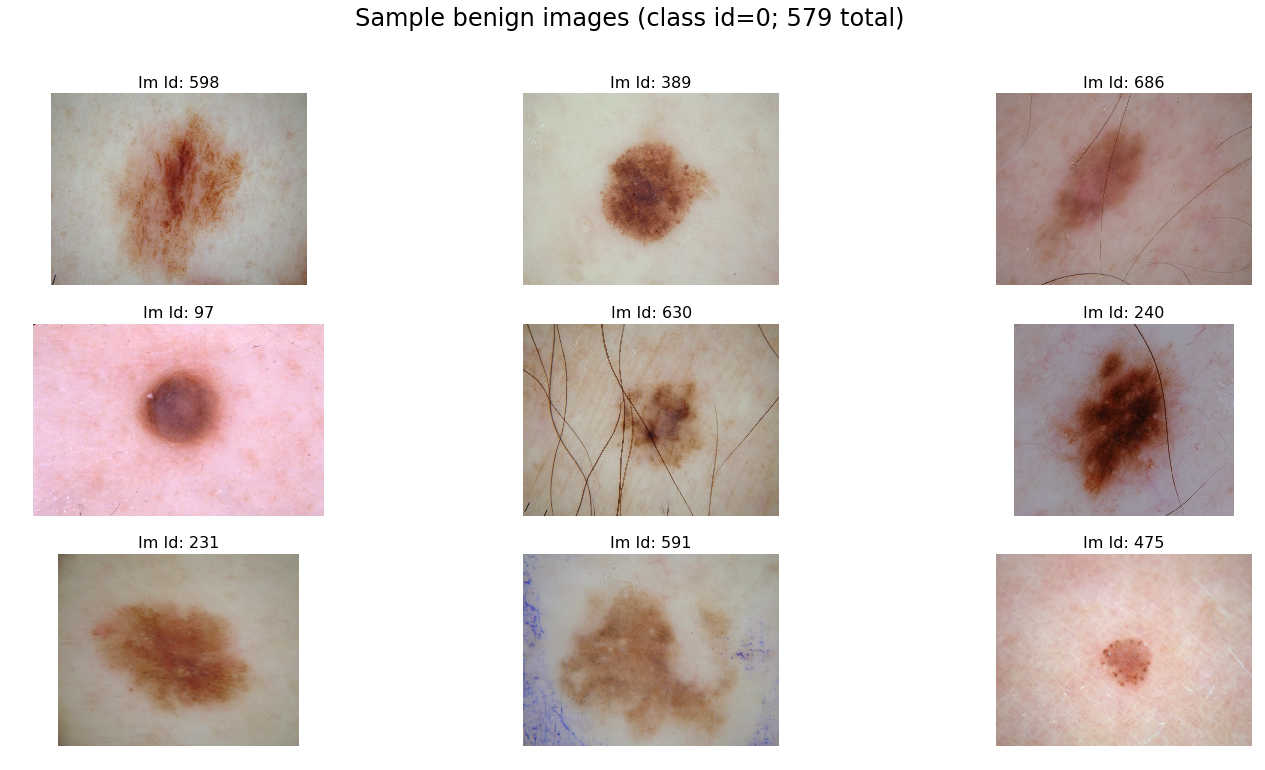

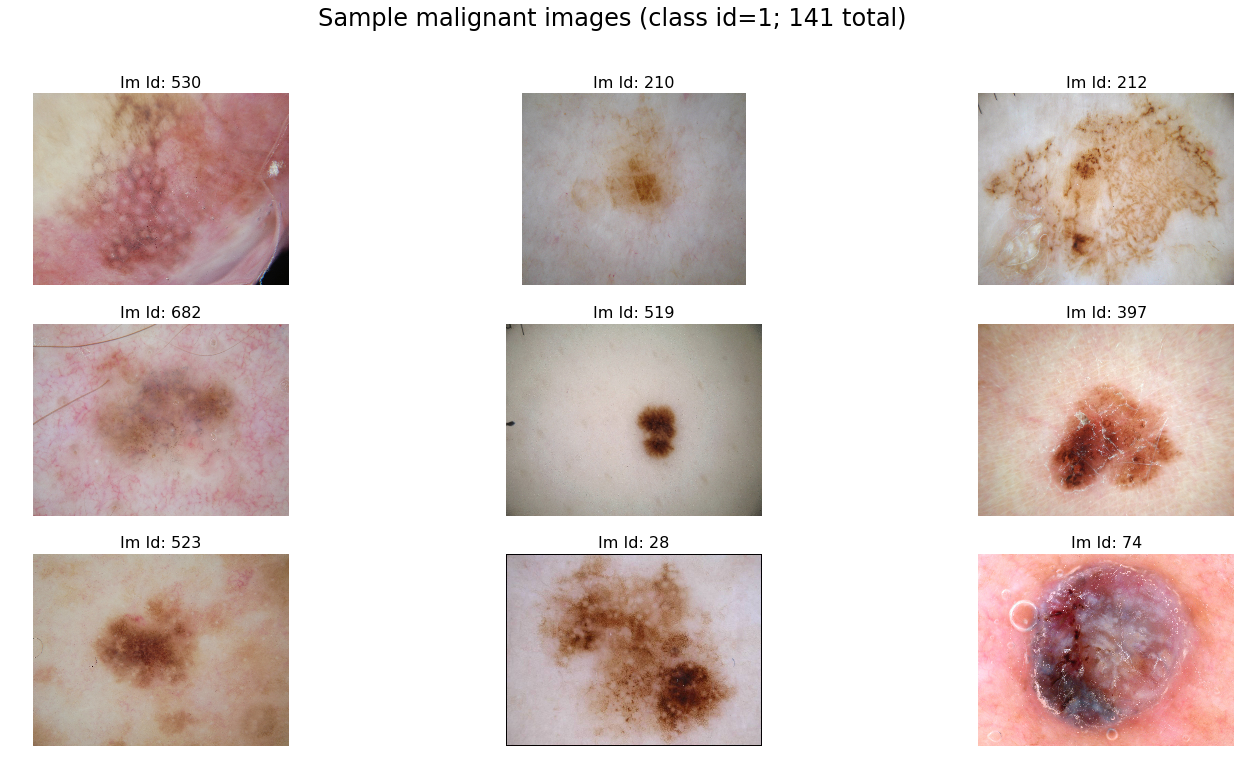

In [13]:
for i in range(min(len(data.classes),10)): sample_ims(i)

In [62]:
data.trn_ds.n

720

In [63]:
data.val_ds.n

180

In [64]:
data.test_ds.n

379

In [65]:
x,y = next(iter(data.val_dl))

In [66]:
x[0].shape

torch.Size([3, 224, 224])

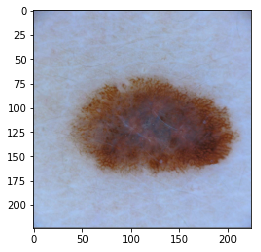

In [67]:
plt.imshow(data.val_ds.denorm(to_np(x))[1])

## Train Model

In [24]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 48/48 [00:04<00:00, 10.97it/s]


 56%|█████▌    | 50/90 [00:00<00:00, 498.49it/s, loss=0.838]


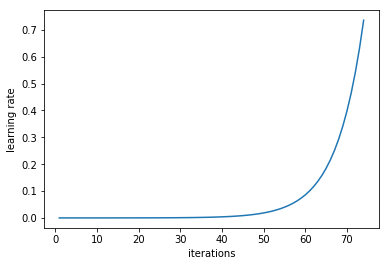

In [26]:
learn.data.bs = 16
lrf=learn.lr_find()
learn.sched.plot_lr()

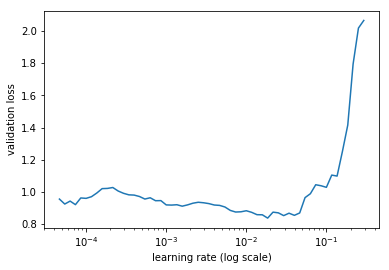

In [27]:
learn.sched.plot()

In [28]:
learn.data.bs = bs
learn.fit(1e-3, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      0.68604    0.478525   0.761111  
    1      0.537621   0.459793   0.783333                   



[array([0.45979]), 0.7833333333333333]

In [29]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      0.638191   0.575928   0.783333  
    1      0.620273   0.581234   0.8                       
    2      0.62334    0.565055   0.75                       



[array([0.56506]), 0.75]

In [83]:
learn.save('ISB2016_224_pre_5ep')

In [85]:
learn.fit(1e-3, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy        
    0      0.467363   0.47009    0.805556  
    1      0.449227   0.466696   0.816667        
    2      0.439445   0.47288    0.822222        



[array([0.47288]), 0.8222222248713176]

In [86]:
learn.save('ISB2016_224_pre_9ep')

In [30]:
learn.precompute = False
learn.fit(1e-3, 4, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.583916   0.54846    0.794444  
    1      0.555409   0.585415   0.783333                  
    2      0.510781   0.557505   0.811111                  
    3      0.51932    0.543295   0.811111                  
    4      0.52134    0.524024   0.8                       
    5      0.425114   0.535062   0.805556                  
    6      0.425636   0.522814   0.788889                  
    7      0.467797   0.516258   0.805556                  
    8      0.478413   0.4915     0.816667                  
    9      0.467045   0.511735   0.8                       
    10     0.440268   0.478825   0.794444                  
    11     0.383716   0.488462   0.811111                  
    12     0.422077   0.470366   0.827778                  
    13     0.419349   0.484524   0.822222                  
    14     0.416495   0.473957   0.822222                  



[array([0.47396]), 0.8222222222222222]

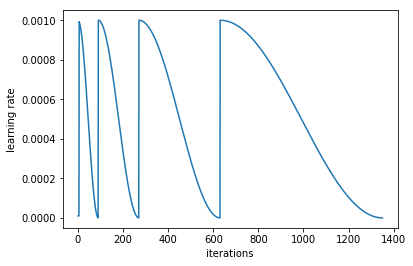

In [31]:
learn.sched.plot_lr()

In [32]:
learn.save('inceptionv4_224_ISB2016')

In [46]:
learn.load('inceptionv4_224_ISB2016')

In [44]:
# unfreeze earlier layers for additional ft'ing
learn.data.bs = 8
learn.unfreeze()
lrs = np.array([1e-5,1e-4,1e-3]) 

In [48]:
learn.fit(lrs, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.476502   0.464629   0.816667  
    1      0.462779   0.529899   0.755556                  


[array([0.5299]), 0.7555555555555555]

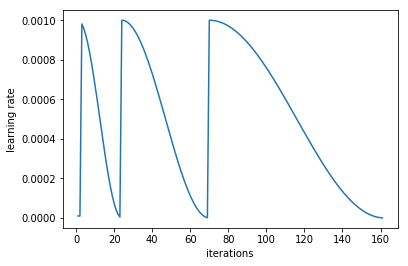

In [109]:
learn.sched.plot_lr()

In [35]:
learn.save('ISB2016_224_pre')

In [10]:
learn.load('ISB2016_224_pre_9ep')

In [166]:
print(learn.opt_fn)

<function SGD_Momentum.<locals>.<lambda> at 0x7fa2706530d0>


# Visualisation

In [33]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct, preds, val_y): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == val_y)==is_correct) & (val_y == y), mult)

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    p_str = '{}\nGT: {}\nPred: {}'
    title_probs = [p_str.format(round(probs[x],2), data.classes[data.val_y[x]], data.classes[preds[x]]) for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

## Validation set

In [91]:
log_preds = learn.predict()

In [92]:
log_preds.shape, log_preds[0:10,:]

((180, 2), array([[-0.07468, -2.63163],
        [-0.31948, -1.29656],
        [-0.05031, -3.01454],
        [-0.21155, -1.65722],
        [-0.32851, -1.27295],
        [-0.0338 , -3.40424],
        [-0.3199 , -1.29543],
        [-0.07534, -2.62314],
        [-0.01069, -4.54372],
        [-0.61899, -0.77325]], dtype=float32))

In [93]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
# probs = np.exp(log_preds[:,1]) 
probs = np.exp(log_preds[np.arange(log_preds.shape[0]), preds])

In [97]:
preds[0:10], data.val_y[0:10], data.val_y.shape

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0]),
 (180,))

In [95]:
preds.shape

(180,)

Correctly classified


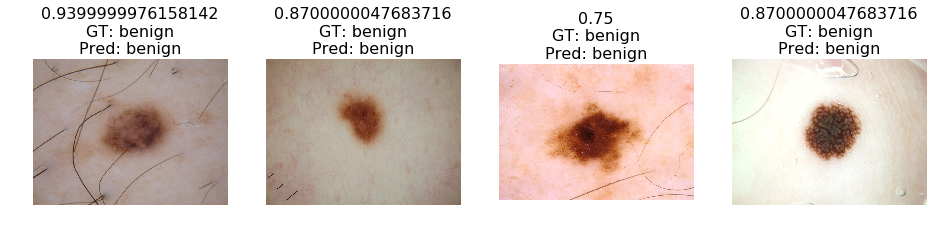

In [98]:
plot_val_with_title(rand_by_correct(True, preds, data.val_y), "Correctly classified")

Incorrectly classified


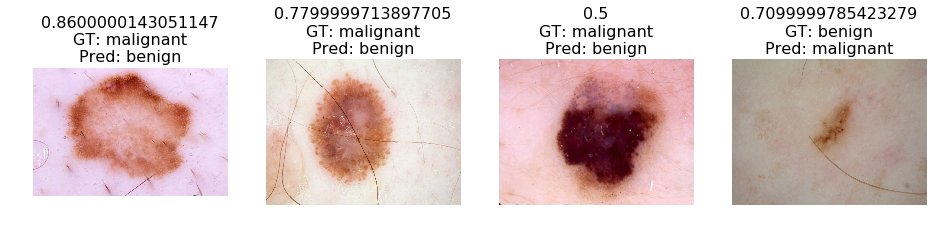

In [99]:
# A few incorrect labels at random
plot_val_with_title(rand_by_correct(False, preds, data.val_y), "Incorrectly classified")

Most correct benign


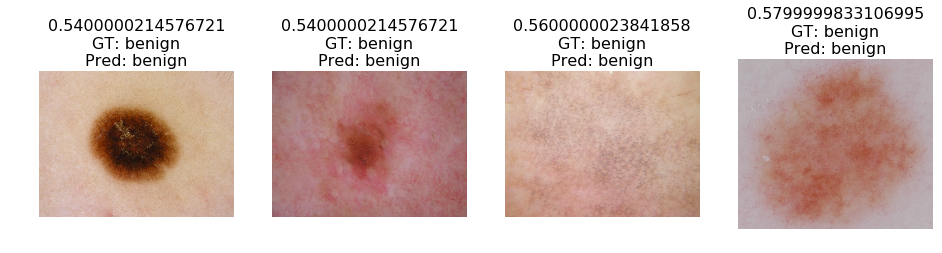

In [100]:
cls = 0
plot_val_with_title(most_by_correct(cls, True, preds, data.val_y), "Most correct {}".format(data.classes[cls]))

In [ ]:
cls = 1
plot_val_with_title(most_by_correct(cls, False, preds, data.val_y), "Most correct {}".format(data.classes[cls]))

## Performance on Validation Set

In [34]:
import sklearn.metrics as metrics
from fastai.plots import plot_confusion_matrix
test_csv = PATH / 'test.csv'

In [35]:
test_gt_csv = PATH / 'ISBI2016_ISIC_Part3_Test_GroundTruth.csv'
df = pd.read_csv(test_gt_csv, header=None)
df.columns = ['image', 'class']
df.set_index('image', inplace=True)
df.to_csv(test_csv)
df.head()

,class
image,
ISIC_0000003,0.0
ISIC_0000012,0.0
ISIC_0000013,1.0
ISIC_0000014,0.0
ISIC_0000015,0.0


In [37]:
def load_csv_labels(csv_, folder='ISBI2016_ISIC_Part3_Test_Data', s='.jpg'):
    _, y, _ = csv_source(folder, csv_, suffix=s)
    print('Loading ys from csv; shape {}; vals {}'.format(y.shape, np.unique(y)))
    return y
    
def run_test(learner, ts=False, test_csv=test_csv, sf=False):
    '''
    Generate values for printing or plotting the three metrics:
    confusipon matrix (cm)
    ROC curve values
    Accuracy value
    
    Should work for binary and multi-task classification problems
    '''
    log_preds, y = learner.TTA(is_test=ts)
    if ts and np.all(y==0):
        y = load_csv_labels(csv_=test_csv)
    probs = np.exp(log_preds).mean(axis=0) # average of TTA
    final_preds = np.argmax(probs, 1)
#     set_trace()
    # accuracy
    acc = metrics.accuracy_score(y,final_preds)
    print(f'Accuracy = %0.2f' % acc)
    # confusion matrix
    cm = metrics.confusion_matrix(y, final_preds)
    print(f'Confusion Matrix:\n{cm}')
    # ROC curve values
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(len(learner.data.classes)):
        cy = np.array(y == i).astype(int)
        cp = probs[:,i]
        fpr[i], tpr[i], _ = metrics.roc_curve(cy, cp)
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        print('AUC for class {}, id {} = {:0.2f}'.format(i, learner.data.classes[i], roc_auc[i]))

    if sf:
        print('-'*40)
        performance_figs(learner.data.classes, cm, roc_auc, fpr, tpr)
    return final_preds, y, acc, cm, roc_auc, fpr, tpr

def performance_figs(classes, cm, roc_auc, fpr, tpr):
    plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues)
    for i in range(len(classes)):
        plt.figure()
        lw = 2
        plt.plot(fpr[i], tpr[i], color='darkorange',
                 lw=lw, label='AUC (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC for {} id {}'.format(classes[i], i))
        plt.legend(loc="lower right")
        plt.show()

In [38]:
vf_preds, vy, vacc, vcm, vroc_auc, vfpr, vtpr = run_test(learn)

Accuracy = 0.83                              
Confusion Matrix:
[[145   3]
 [ 28   4]]
AUC for class 0, id benign = 0.70
AUC for class 1, id malignant = 0.70


Text(0.5,1,'Val network predictions distribution')

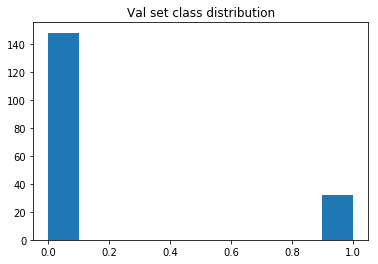

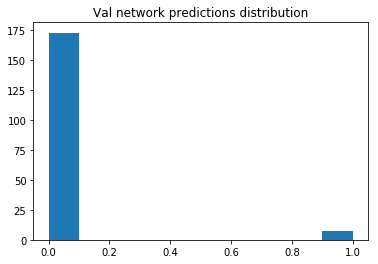

In [39]:
plt.hist(vy, align='mid')
plt.title('Val set class distribution')
plt.figure()
plt.hist(vf_preds, align='mid')
plt.title('Val network predictions distribution')

## Performance on Test Set

Loading ys from csv; shape (379,); vals [0 1]
Accuracy = 0.78
Confusion Matrix:
[[295   9]
 [ 73   2]]
AUC for class 0, id benign = 0.50
AUC for class 1, id malignant = 0.50
----------------------------------------
[[295   9]
 [ 73   2]]


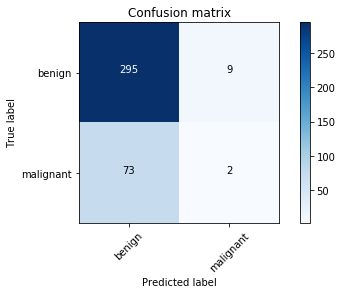

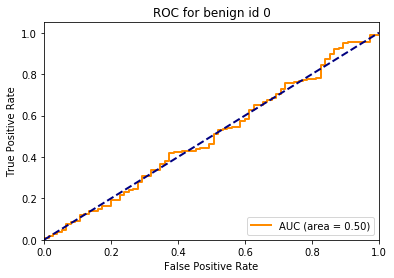

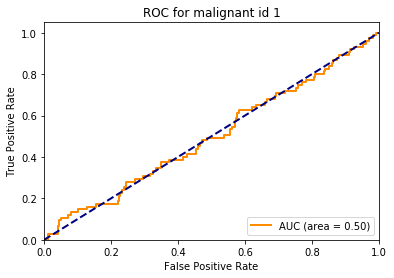

In [49]:
tf_preds, ty, tacc, tcm, troc_auc, tfpr, ttpr = run_test(learn, ts=True, sf=True)

In [29]:
ty[0:10], learn.data_.test_ds.fnames[0:10]

(array([0, 0, 1, 0, 0, 0, 1, 0, 0, 1]),
 ['ISBI2016_ISIC_Part3_Test_Data/ISIC_0000449.jpg',
  'ISBI2016_ISIC_Part3_Test_Data/ISIC_0010173.jpg',
  'ISBI2016_ISIC_Part3_Test_Data/ISIC_0000328.jpg',
  'ISBI2016_ISIC_Part3_Test_Data/ISIC_0011162.jpg',
  'ISBI2016_ISIC_Part3_Test_Data/ISIC_0009928.jpg',
  'ISBI2016_ISIC_Part3_Test_Data/ISIC_0010556.jpg',
  'ISBI2016_ISIC_Part3_Test_Data/ISIC_0010037.jpg',
  'ISBI2016_ISIC_Part3_Test_Data/ISIC_0000057.jpg',
  'ISBI2016_ISIC_Part3_Test_Data/ISIC_0000040.jpg',
  'ISBI2016_ISIC_Part3_Test_Data/ISIC_0000515.jpg'])

Text(0.5,1,'Test network predictions distribution')

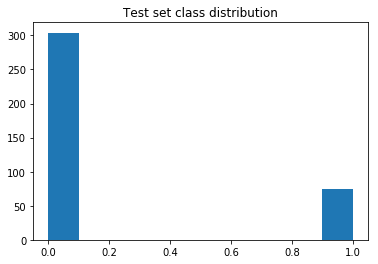

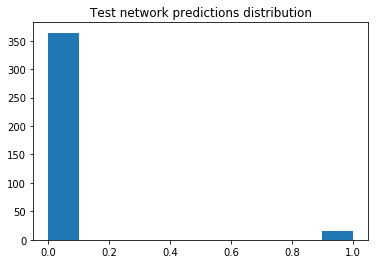

In [24]:
plt.hist(ty, align='mid')
plt.title('Test set class distribution')
plt.figure()
plt.hist(tf_preds, align='mid')
plt.title('Test network predictions distribution')